In [1]:
from pyspark.sql import SparkSession


In [2]:
spark = SparkSession.builder.appName("first_paquet").config("spark.jars.packages", "org.postgresql:postgresql:42.7.3").getOrCreate()
df = spark.read.parquet("../data/dataset.parquet")
df.printSchema()
df.show(5)


26/01/09 16:49:43 WARN Utils: Your hostname, hp-HP-EliteBook-Folio-9480m resolves to a loopback address: 127.0.1.1; using 192.168.1.177 instead (on interface wlo1)
26/01/09 16:49:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hp/.ivy2/cache
The jars for the packages stored in: /home/hp/.ivy2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-34ee05f4-1ac3-4c32-a476-bd50618749f5;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.3 in central
	found org.checkerframework#checker-qual;3.42.0 in central
:: resolution report :: resolve 293ms :: artifacts dl 15ms
	:: modules in use:
	org.checkerframework#checker-qual;3.42.0 from central in [default]
	org.postgresql#postgresql;42.7.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------------------------------

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [3]:
#spark.stop()

In [4]:
df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [5]:
print(df.count())
len(df.columns)

3475226


20

In [6]:
type(df)

pyspark.sql.dataframe.DataFrame

# Count the number of null values in each columns

In [7]:
from pyspark.sql.functions import col, sum
df.select([sum(col(c).isNull().cast("int")).alias(c + "_nulles") for c in df.columns]).count()



1

# check for outliers

In [8]:
import pyspark as ps
# pdf['fare_amount'].plot.box()


# Deal with null values

In [9]:
df.na.drop().show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [10]:
df.count()

3475226

# Create dure_trajet Column

In [11]:
type(df)

pyspark.sql.dataframe.DataFrame

In [12]:
import pyspark.sql.functions as sf
df = df.withColumn("dure_trajet", (sf.unix_timestamp(sf.col("tpep_dropoff_datetime"))- sf.unix_timestamp(sf.col("tpep_pickup_datetime")))/60)

In [13]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|       dure_trajet|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|    

In [14]:
df.describe().show()

26/01/09 16:50:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|        dure_trajet|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+---------

# Search columns  with the same value duplicates over the columns 

In [15]:
df.select("trip_distance").distinct().count()

4545

In [16]:
for col in df.columns:
    val= df.select(col).distinct().count()
    rows_count= df.count()
    if val <= 4:
      print(col)
      print(val)    #    print(col)

VendorID
4


store_and_fwd_flag
3
improvement_surcharge
4
congestion_surcharge
4
cbd_congestion_fee
3


# Select the Categorial Columns

In [17]:
categrial_df= df.select("dure_trajet","VendorID", "RatecodeID", "store_and_fwd_flag","payment_type","PULocationID","DOLocationID")
categrial_df.show(2)

+-----------+--------+----------+------------------+------------+------------+------------+
|dure_trajet|VendorID|RatecodeID|store_and_fwd_flag|payment_type|PULocationID|DOLocationID|
+-----------+--------+----------+------------------+------------+------------+------------+
|       8.35|       1|         1|                 N|           1|         229|         237|
|       2.55|       1|         1|                 N|           1|         236|         237|
+-----------+--------+----------+------------------+------------+------------+------------+
only showing top 2 rows



# Analyse the relation between Categorial data and the target

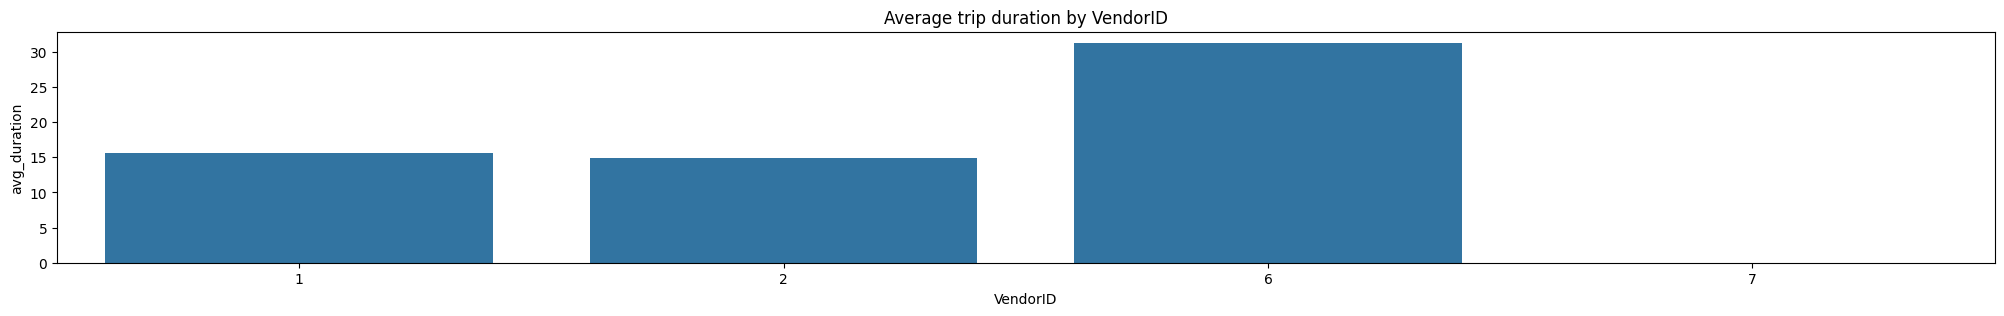

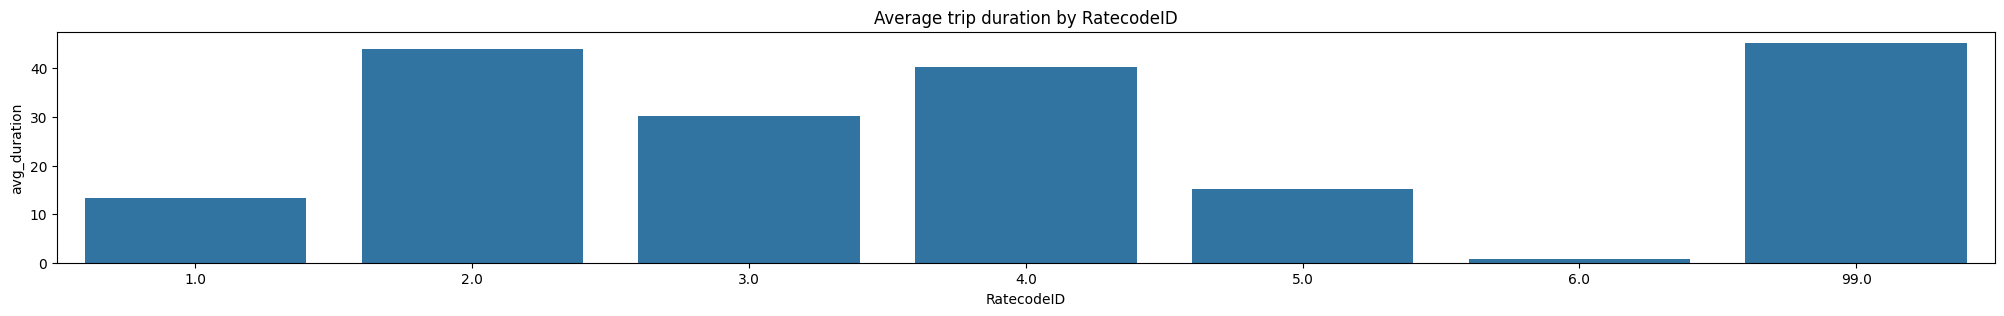

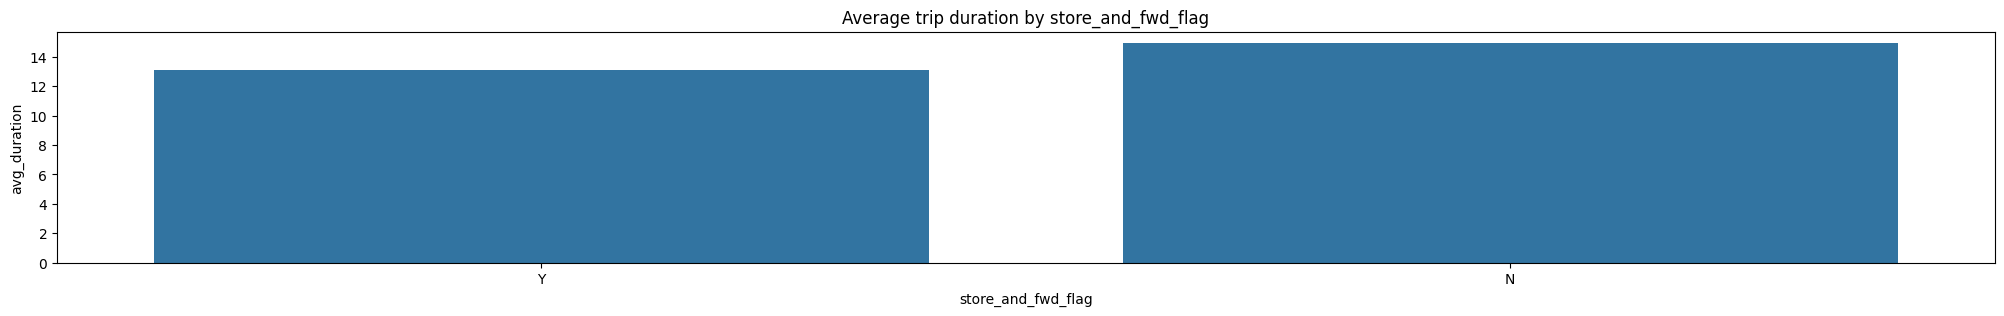

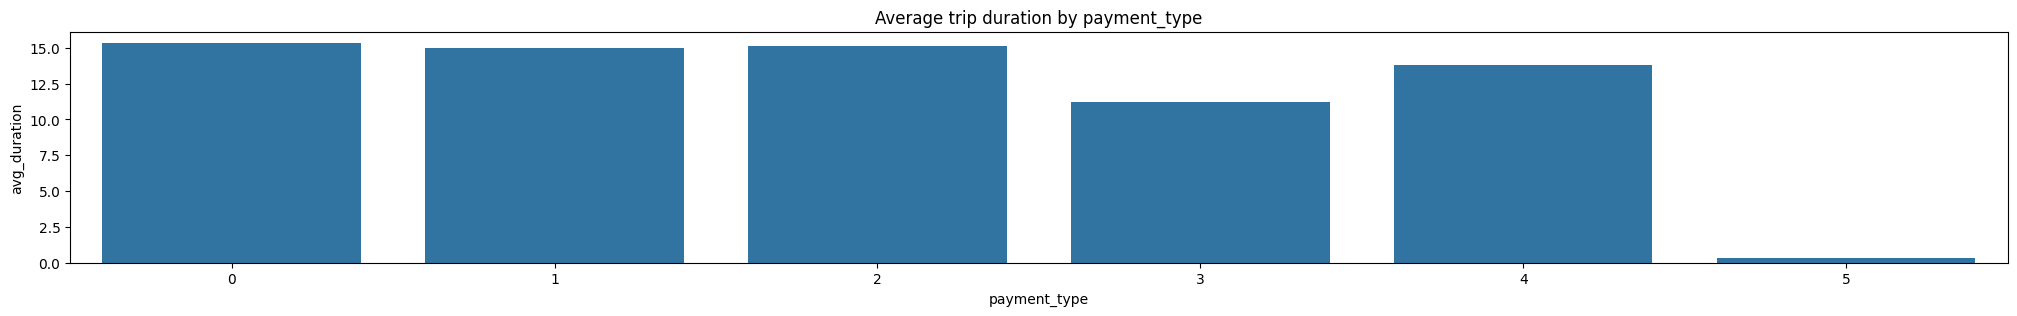

In [18]:
# categrial_df.plot.countplot(x='VendorID', y='dure_trajet')

from pyspark.sql.functions import count
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg
categorical_cols = ["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type"]

for col in categorical_cols:
   agg = (
    categrial_df.groupBy(col).agg(avg("dure_trajet").alias("avg_duration"))
)
   pdf = agg.toPandas()    
   plt.figure(figsize= (25,3))
   sns.barplot(data=pdf, x=col, y="avg_duration")
   plt.title(f"Average trip duration by {col}")
   plt.show()


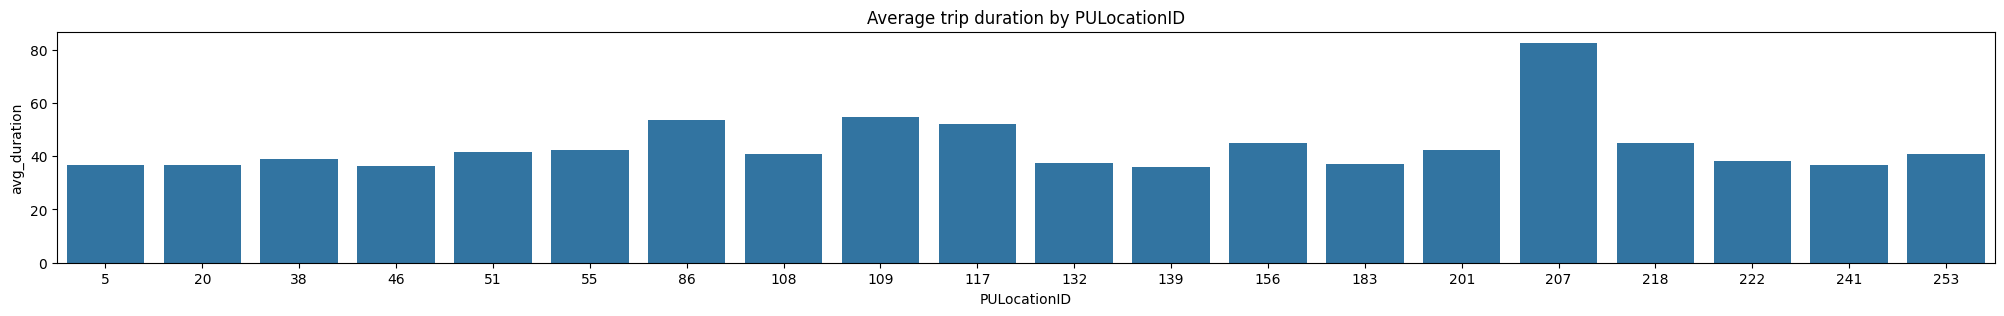

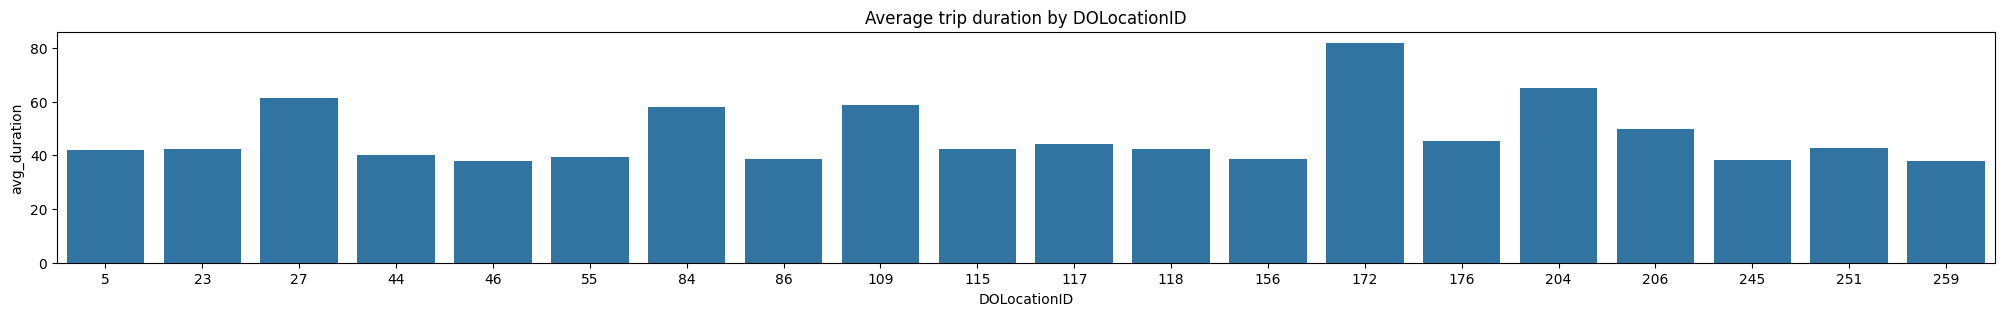

In [19]:
from pyspark.sql.functions import avg, desc

high_categorial_cols= ["PULocationID","DOLocationID"]
for col in high_categorial_cols:
   agg = (
    categrial_df.groupBy(col).agg(avg("dure_trajet").alias("avg_duration")).orderBy(desc("avg_duration")).limit(20)
    )
   pdf = agg.toPandas()    
   plt.figure(figsize= (25,3))
   sns.barplot(data=pdf, x=col, y="avg_duration")
   plt.title(f"Average trip duration by {col}")
   plt.show()


# Select the Numerical Features

In [20]:
numerical_df= df.select("dure_trajet","passenger_count", "trip_distance", "fare_amount","extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","Airport_fee","cbd_congestion_fee")
numerical_df.show(2)

+-----------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|dure_trajet|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+-----------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       8.35|              1|          1.6|       10.0|  3.5|    0.5|       3.0|         0.0|                  1.0|        18.0|                 2.5|        0.0|               0.0|
|       2.55|              1|          0.5|        5.1|  3.5|    0.5|      2.02|         0.0|                  1.0|       12.12|                 2.5|        0.0|               0.0|
+-----------+---------------+-------------+-----------+-----+-------+----------+------------+--

<class 'pyspark.ml.feature.VectorAssembler'>


26/01/09 16:51:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<Axes: >

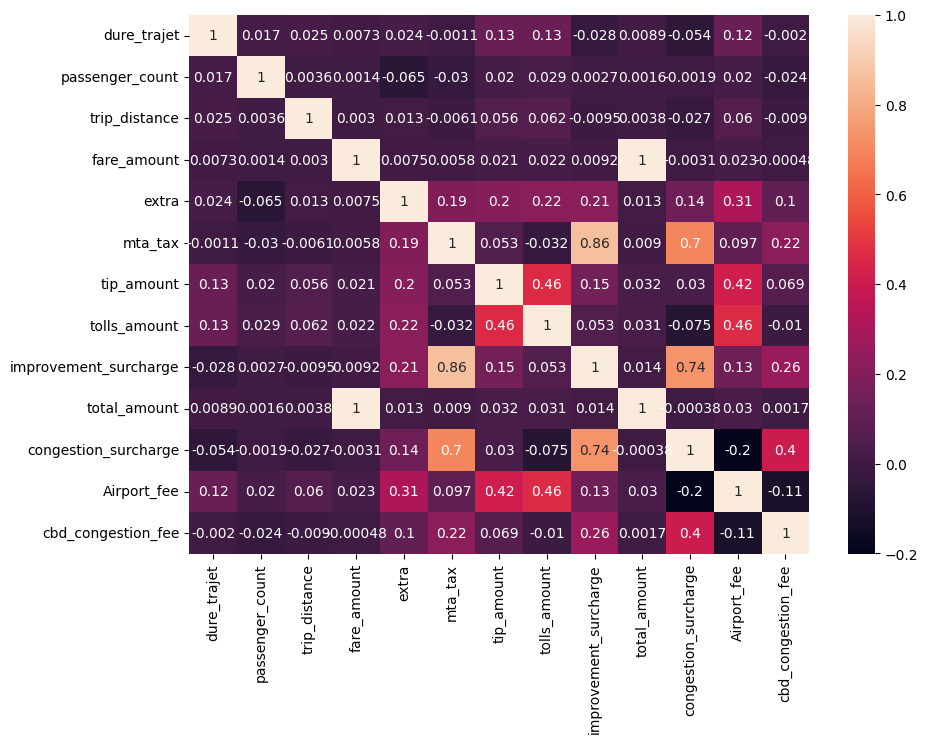

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(10,7))
vector_col= "assembled_features"
assembler= VectorAssembler(inputCols= numerical_df.columns, outputCol=vector_col, handleInvalid="skip")
print(type(assembler))

df_vector= assembler.transform(numerical_df).select(vector_col)
# df_vector.show(2)
corr_matrix= Correlation.corr(df_vector, vector_col)
matrix_array = corr_matrix.collect()[0][0].toArray()
pd_matrix = pd.DataFrame(matrix_array, columns=numerical_df.columns, index=numerical_df.columns)
# print(matrix_array)
matrix_df= spark.createDataFrame(pd_matrix, numerical_df.columns)

sns.heatmap(pd_matrix, annot=True)




# Filter Data

In [22]:
# Filter data
from pyspark.sql.functions import col

df_filter= df.filter((col("trip_distance")> 0) & (col("trip_distance")<200 ) & ( col("dure_trajet") > 0) & (col("passenger_count") > 0))
df_filter.show(10)
print(df_filter.count())

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|       dure_trajet|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|    

2871275


# Look for outliers

I decided to delete thoese columns: 

**iqr method**

In [23]:
from pyspark.sql.functions import when 

def data_cleaning(df):
      df_filter= df.filter((col("trip_distance")> 0) & (col("trip_distance")<200 ) & ( col("dure_trajet") > 0) & (col("passenger_count") > 0))
      df_filter =df_filter.drop("fare_amount","mta_tax", "total_amount","cbd_congestion_fee","store_and_fwd_flag", "extra","improvement_surcharge")
      #am not goign to unclude passenger_count because it have limited values
      numerical_df_cols_no_target= df_filter.select("trip_distance","tip_amount","tolls_amount","congestion_surcharge","Airport_fee")
      for feature in numerical_df_cols_no_target.columns:
         quartilles = numerical_df_cols_no_target.approxQuantile(feature, [0.25,0.50, 0.75],0) #0 err

         iqr = quartilles[2] - quartilles[0]
         uper_bound= quartilles[2] + 1.5 * iqr
         lower_bound= quartilles[0] - 1.5 * iqr

         cleaned_df= df.withColumn( 
              feature,
              when(col(feature)>uper_bound , uper_bound) 
              .when(col(feature) < lower_bound , lower_bound)
              .otherwise(col(feature))
         )
         print(feature, quartilles)
      return cleaned_df
      
df_clean = data_cleaning(df)
df_clean.show(5)

trip_distance [0.99, 1.62, 3.01]


tip_amount [1.0, 2.85, 4.21]


tolls_amount [0.0, 0.0, 0.0]


congestion_surcharge [2.5, 2.5, 2.5]


Airport_fee [0.0, 0.0, 0.0]
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|      dure_trajet|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:2

# download data to postgreSQL

In [24]:
print(spark.sparkContext._conf.get("spark.jars.packages"))


org.postgresql:postgresql:42.7.3


In [25]:
df.write \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/taxi_eta") \
  .option("dbtable", "taxis") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .mode("overwrite") \
  .save()

In [ ]:
def save_data(df):
    df.write \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/taxi_eta") \
  .option("dbtable", "taxis") \
  .option("user", "postgres") \
  .option("password", "postgres") \
  .option("driver", "org.postgresql.Driver") \
  .mode("overwrite") \
  .save()


# Encodage

In [ ]:
from pyspark.ml.feature import OneHotEncoder;
encoder = OneHotEncoder()
categorical_cols= ["PULocationID","DOLocationID"]
for col in categorical_cols:
   cleaned_df= df.withColumn( 
              col,
              when(col== "PULocationID" , encoder.fit(col).transform(col)) 
              .otherwise(col(col))
         )


 # Normalisation

## Medallion architecture

## 1. bronze

In [26]:
#load data fct
def load_data():
    spark = SparkSession.builder.appName("first_paquet").getOrCreate()
    df = spark.read.parquet("../data/dataset.parquet")
    df.show(5)
load_data()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

## 2.Silver

In [27]:
from pyspark.sql.functions import when 

def data_cleaning(df):
      df_filter= df.filter((col("trip_distance")> 0) & (col("trip_distance")<200 ) & ( col("dure_trajet") > 0) & (col("passenger_count") > 0))
      df_filter =df_filter.drop("fare_amount","mta_tax", "total_amount","cbd_congestion_fee","store_and_fwd_flag", "extra","improvement_surcharge")
      #am not goign to unclude passenger_count because it have limited values
      numerical_df_cols_no_target= df_filter.select("trip_distance","tip_amount","tolls_amount","congestion_surcharge","Airport_fee")
      for feature in numerical_df_cols_no_target.columns:
         quartilles = numerical_df_cols_no_target.approxQuantile(feature, [0.25,0.50, 0.75],0) #0 err

         iqr = quartilles[2] - quartilles[0]
         uper_bound= quartilles[2] + 1.5 * iqr
         lower_bound= quartilles[0] - 1.5 * iqr

         cleaned_df= df.withColumn( 
              feature,
              when(col(feature)>uper_bound , uper_bound) 
              .when(col(feature) < lower_bound , lower_bound)
              .otherwise(col(feature))
         )
         print(feature, quartilles)
      return cleaned_df
      
df_clean = data_cleaning(df)
df_clean.show(5)

trip_distance [0.99, 1.62, 3.01]


tip_amount [1.0, 2.85, 4.21]


tolls_amount [0.0, 0.0, 0.0]


congestion_surcharge [2.5, 2.5, 2.5]


Airport_fee [0.0, 0.0, 0.0]
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|      dure_trajet|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:2